### Binary Logistic Regression (dim = 2)

N = 1000

N_train = 500

N_test = 200

polynomials_max_deg = 3

$f(\theta) = \theta_1 + \theta_2 $

$K=2$

In [97]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

## BLR data generation

In [98]:
d = 2
def r(theta, x):
    return np.exp(theta.T @ x)/(1+np.exp(theta.T @ x))
def generate_data(p, n):
    X = np.empty((n,p))
    Y = np.empty(n)
    for i in range(n):
        prob = multivariate_normal.rvs(0,1,p)
        X[i, prob < 0] = -1
        X[i, prob >= 0] = +1
        X[i] = X[i]/np.linalg.norm(X[i])
        Y[i] = bernoulli.rvs(r(np.ones(p),X[i].reshape(p,1)))
    return X,Y.reshape((n,1))

In [99]:
np.random.seed(55)
X_reg, Y_reg = generate_data(2,100)

In [100]:
def sigma(X):
    n = X.shape[0]
    p = X.shape[1]
    S = np.zeros((p,p))
    for i in range(n):
        S = S + X[i].reshape((p,1)) @ X[i].reshape(1,p)
    return S 
    
def f_grad(theta, X, Y, Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    LOG = np.zeros((p,1))
    for i in range(n):
        LOG = LOG + X[i].reshape((p,1)) / (1+np.exp(theta.T @ X[i].reshape((p,1))))
    F = X.T @ Y - LOG + lambda_c * Sigma @ theta
    return F

def MLE(X,Y,Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    eps = 1e-6
    mu = np.max(np.linalg.eigvals(Sigma))
    M = (lambda_c + 0.25*n) * mu
    theta_k =[]
    theta_k.append(np.ones((p,1)))
    theta_k.append(theta_k[0] - 1/(2*M) * f_grad(theta_k[0],X,Y,Sigma))
    i = 2
    while(np.linalg.norm(theta_k[i-1] - theta_k[i-2])**2 > eps**2):
        theta_k.append(theta_k[i-1] - 1/(2*M) * f_grad(theta_k[i-1],X,Y,Sigma))
        i = i+1
    return theta_k[-1]    

## MLE estimator of parameter vector

In [101]:
Sigma = sigma(X_reg)
MLE(X_reg,Y_reg,Sigma)

array([[-0.25514325],
       [-0.33595237]])

### Parameters inicialization, ULA algorithm

In [102]:
def lmc_regression_without_precond(X,Y,Sigma, N):
    n = X.shape[0]
    p = X.shape[1]   
    h = 0.01
    K = 10000
    #-----------------------------------------------------
    vkh = np.empty((K + N,p,1), dtype=np.float64)
    ksi = multivariate_normal.rvs(np.zeros(p), np.eye(p),K+N).reshape(K+N, p,1)
    vkh[0] = (np.random.normal(0,1,p)).reshape(p,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1], X,Y,Sigma)
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

### Sample generation

In [103]:
np.random.seed(42)
X, Z = lmc_regression_without_precond(X_reg,Y_reg,Sigma, 10000)

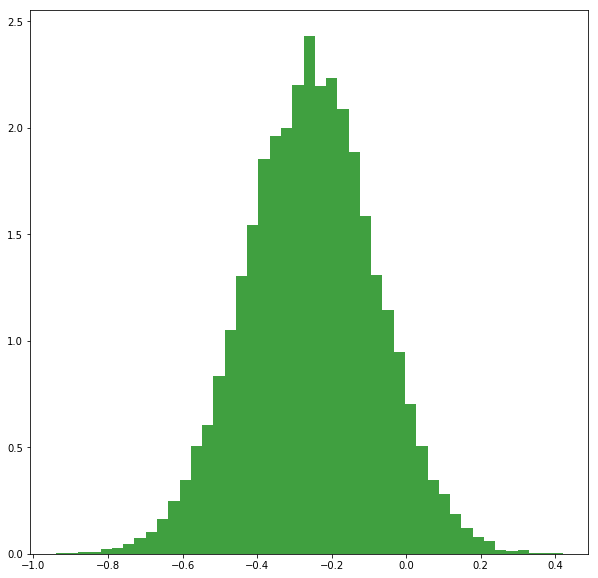

In [104]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,0].reshape(-1,1), 45, density=True, facecolor='g', alpha=0.75)
plt.show()

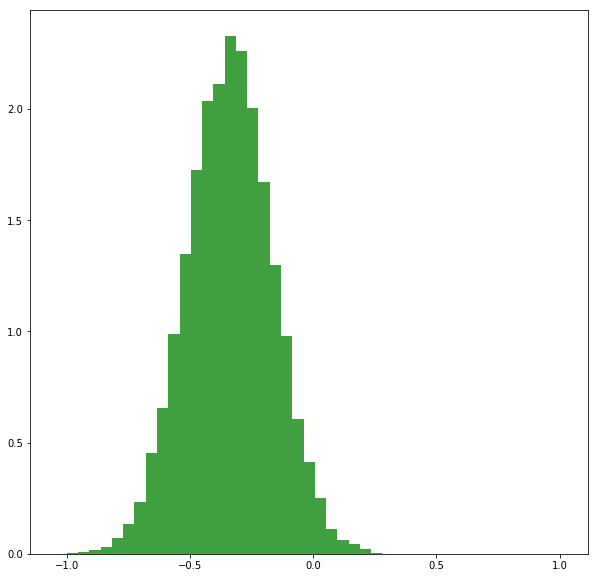

In [105]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X[:,1].reshape(-1,1), 45, density=True, facecolor='g', alpha=0.75)
plt.show()

### Ordinary weighted estimator with $$f(x_1, x_2) = e^{-x_1} + 7x_2^2$$

In [106]:
def local_weighted_estimator(X):
    return (X[:,0] + X[:,1]).mean()

In [107]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.593777630512


### Generation of N_train independent paths

In [108]:
def generate_lmc_from_initial(x_initial,Sigma,N):
    h = 0.01
    vkh = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1], X_reg,Y_reg,Sigma)
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

def generate_paths(x_initial,N_train,Sigma,N):
    XX = []
    ZZ = []
    for i in range(N_train):
        X, Z = generate_lmc_from_initial(x_initial[-i],Sigma,N)
        XX.append(X)
        ZZ.append(Z)
    return np.array(XX),np.array(ZZ)

In [15]:
np.random.seed(123)
XX, ZZ = generate_paths(X,50,Sigma,1000)

### (normalized) Hermite polynomials

In [109]:
def generate_k_vec(d, K):
    r = list(range(K+1))
    k = []
    for roll in product(r, repeat = d):
        k.append(list(roll))
    k.remove([0,0])
    return k
def H(k, x):
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

In [110]:
k_comb = generate_k_vec(d,1)
k_comb

[[0, 1], [1, 0], [1, 1]]

### Fitting linear regression for $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right]$

In [111]:
def pol_ar_1d(x): #x.shape = (2,1)
    return np.array([1,x[0],x[1],x[0]*x[1],x[0]**2,x[1]**2,x[0]**2 *x[1],x[0]* x[1]**2, x[0]**3, x[1]**3])

def generate_X_reduced(XX, r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    X = np.empty((N_train * (N-r) ,10))
    all_points = XX[:, :N-r].reshape(-1,2)
    X[:,0] = np.ones(N_train * (N-r))
    X[:,1] = all_points[:,0].squeeze()
    X[:,2] =all_points[:,1].squeeze()
    X[:,3] = (all_points[:,0] * all_points[:,1]).squeeze()
    X[:,4] = (all_points[:,0]**2).squeeze()
    X[:,5] = (all_points[:,1]**2).squeeze()
    X[:,6] = (all_points[:,0]**2 * all_points[:,1]).squeeze()
    X[:,7] = (all_points[:,0] * all_points[:,1]**2).squeeze()
    X[:,8] = (all_points[:,0]**3).squeeze()
    X[:,9] = (all_points[:,1]**3).squeeze()
    return X 


def generate_y_reduced(XX,r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    y = np.zeros(N_train * (N-r))
    y = XX[:, r:].sum(axis = 2).reshape(-1)
    return y

def G_pml_fit(XX):
    N_train = XX.shape[0]
    N = XX.shape[1]
    Betas = np.zeros((N,10))
    for r in tqdm(range(N)):
        X = generate_X_reduced(XX,r)
        y = generate_y_reduced(XX,r)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas

def G_pml_predict(x,pml,Betas):
    x_pol = pol_ar_1d(x)
    beta = Betas[pml]
    return (x_pol @ beta)

In [20]:
Betas = G_pml_fit(XX)

100%|██████████| 1000/1000 [00:08<00:00, 114.79it/s]


In [21]:
np.save('BLR_XX.npy',XX)
np.save('BLR_ZZ.npy',ZZ)
np.save('BLR_Betas.npy',Betas)

In [112]:
Betas = np.load('BLR_Betas.npy')
XX = np.load('BLR_XX.npy')
ZZ = np.load('BLR_ZZ.npy')

In [113]:
degrees = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2],[2,1],[1,2],[3,0],[0,3]])

In [114]:
def a_plk(X,p,l,k_vec):
    h = 0.01
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1],X_reg,Y_reg,Sigma)
    for ind,(i,j) in enumerate(degrees):
        S_small_1 = 0
        S_small_2 = 0
        for t in range (i+1):
            for s in range (int(t/2 +1)):
                if (k_vec[0] == t - 2*s):
                    S_small_1 = S_small_1 + comb(N=i, k = t, exact = True) * x_hat[0]**(i-t) * \
                    math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                else:
                    pass
        for t in range (j+1):
            for s in range (int(t/2 +1)):
                if (k_vec[1] == t - 2*s):
                    S_small_2 = S_small_2 + comb(N=j, k = t, exact = True) * x_hat[1]**(j-t) * \
                    math.factorial(t)*1/math.factorial(s)*1 / np.sqrt(math.factorial(t-2*s)) *np.sqrt(2*h)**t /2**s
                else:
                    pass
        S = S + Betas[p-l,ind] * S_small_1 *S_small_2
    return S

In [115]:
def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

P = estimator(XX)
print ("variance of weighted estimator (1.4) on training sample:",P.var(ddof=1))

100%|██████████| 50/50 [00:00<00:00, 24660.77it/s]

variance of weighted estimator (1.4) on training sample: 0.000271329558705


In [128]:
def M_bias(k_vec,X,Z,Betas):
    N = X.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if (p-l<100):
                s = a_plk(X,p,l,k_vec)* Hermite_val(k_vec,Z[l])
                S = S + s
    return S/N

In [129]:
def estimator_bias(k,XX,ZZ,Betas,first, last):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],Betas)for i in range(first, last))
    return np.array(M_results).reshape(-1)

In [130]:
X = XX[7]
Z = ZZ[7]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(len(k_comb)):
    print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas),timeit.default_timer()-time_1))

P = -0.602861185496
M ([0, 1]) = [-0.01070166] [Time:122.8057805079734]
M ([1, 0]) = [-0.00015962] [Time:244.55160497303586]
M ([1, 1]) = [ 0.0005698] [Time:360.17793308605906]


In [132]:
# X = XX[8]
# Z = ZZ[8]
# time_1 = timeit.default_timer()
# print ("P =",local_weighted_estimator(X))
# for i in range(len(k_comb)):
#     print ("M ({}) = {} [Time:{}]".format(k_comb[i],M_bias(k_comb[i],X,Z,Betas,i),timeit.default_timer()-time_1))

### Check on test

In [59]:
# np.random.seed(9651)
# X, Z = lmc_regression_without_precond(X_reg,Y_reg,Sigma, 10000)

# XX_test, ZZ_test =  generate_paths(X,200,Sigma,1000)

# P_test = estimator(XX_test)

# np.save('BLR_XX_test', XX_test)
# np.save('BLR_ZZ_test', ZZ_test)
# # XX_test = np.load('BLR_XX_test.npy')
# # ZZ_test = np.load('BLR_ZZ_test.npy')

100%|██████████| 2/2 [00:00<00:00, 2706.88it/s]


In [133]:
XX_test = np.load('BLR_XX_test.npy')
ZZ_test = np.load('BLR_ZZ_test.npy')
P_test = estimator(XX_test)

100%|██████████| 50/50 [00:00<00:00, 23260.34it/s]


In [134]:
XX_test.shape

(50, 1000, 2, 1)

In [135]:
print (P_test.var(dtype=np.float64,ddof=1))

0.000304963978348


In [144]:
M_1 = estimator_bias(k_comb[0],XX_test,ZZ_test,Betas, 0, 50)
np.save('BLR_M_results_test_1.npy', M_1)

In [ ]:
M_2 = estimator_bias(k_comb[1],XX_test,ZZ_test,Betas, 0, 50)
np.save('BLR_M_results_test_2.npy', M_2)

In [ ]:
M_3 = estimator_bias(k_comb[2],XX_test,ZZ_test,Betas, 0, 50)
np.save('BLR_M_results_test_3.npy', M_3)

In [141]:
print ('Variance of Pi = ',P_test.var(ddof = 1))
print ('-----------------------------------------------------')
print ('Variance of new estimator (K=1)= ',(P_test-M_1).var(ddof = 1))
print ("=====================================================")
print ('Variance of new estimator (K=1)= ',(P_test-M_1 - M_2).var(ddof = 1))
print ("=====================================================")
print ('Variance of new estimator (K=1)= ',(P_test-M_1 - M_2-M_3).var(ddof = 1))
print ("=====================================================")

Variance of Pi =  0.000304963978348
-----------------------------------------------------
Variance of new estimator (K=1)=  0.000106844776148
Variance of new estimator (K=1)=  6.5647055106e-06
Variance of new estimator (K=1)=  6.24103892633e-06


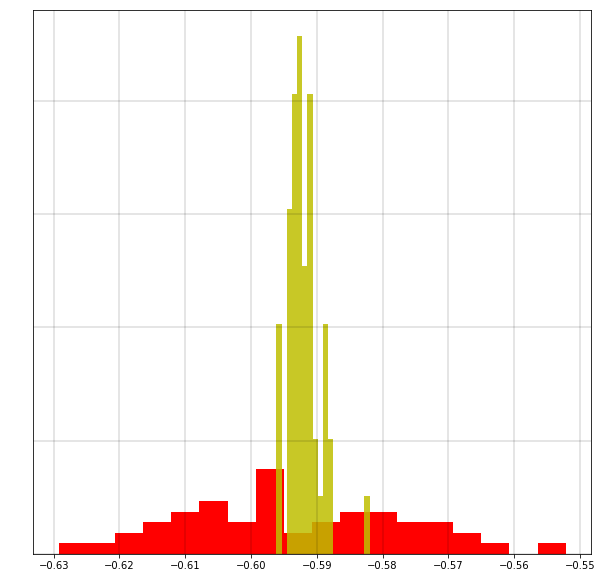

In [142]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(P_test.reshape(-1,1),18, facecolor='r', density=True,
                            alpha=1, label="Distribution of $\pi$")

n, bins, patches = plt.hist((P_test-M_1-M_2 - M_3).reshape(-1,1), 18, density=True, facecolor='y', 
                            alpha=0.85, label="Distribution of $\pi - M^1_N$")

plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
plt.show()

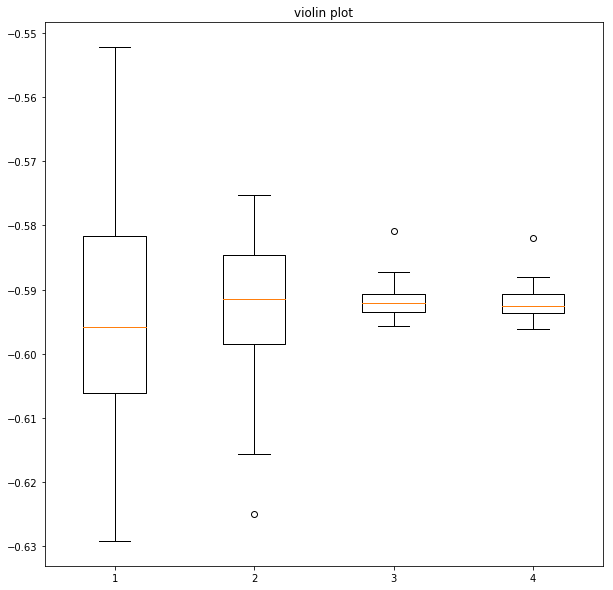

In [143]:
plt.figure(figsize=(10,10))

# generate some random test data
all_data = [P_test, P_test - M_1,P_test - M_1 -M_2,P_test - M_1 - M_2 - M_3]

# plot violin plot
plt.boxplot(all_data)
plt.title('violin plot')

plt.show()